# Non-linear Least Squares and SciPy optimization
### Set up environment

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from scipy.optimize import minimize, check_grad
from pandas.tools.plotting import scatter_matrix

np.set_printoptions(precision = 3, suppress = True)
sns.set_context('notebook')
%matplotlib inline

### Import data

In [2]:
df = pd.read_csv('../data/attendance.csv').dropna()
df.sort_values(by='Attendance', inplace=True)

Y = df['Exam'].values
X = df['Attendance'].values
# Adjust by one to allow for log(X)
X += 1

print(df.head())

    Attendance   Exam
54         1.0  27.50
47         1.0  33.75
50         2.0  30.00
48         2.0  31.25
59         3.0  23.75


### Plot some graphs

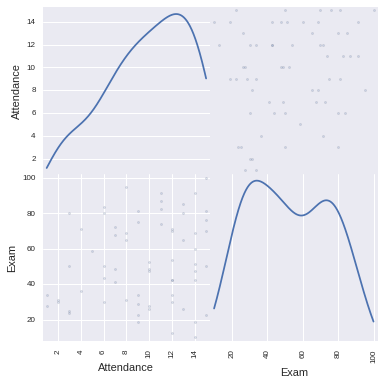

In [3]:
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

## Polynomial model class

In [4]:
class Model_Poly(object):
    
    def __init__(self, Y, X, nterms):
        self.nterms = nterms
        self.Y, self.X = Y, X
        self.N = Y.shape[0]
    
    def xall(self, theta):
        return np.atleast_2d(self.X).T ** list(range(len(theta)))

    def yhat(self, theta):
        return self.xall(theta).dot(theta)

    def sse(self, theta):
        return ((self.Y - self.yhat(theta))**2).mean()

    def jac(self, theta):
        return -2 * (self.Y - self.yhat(theta)).dot(self.xall(theta)) / self.N

    def hess(self, theta):
        return 2 * self.xall(theta).T.dot(self.xall(theta)) / self.N

## Power model class

In [5]:
class Model_Power(object):
    
    def __init__(self, Y, X):
        self.Y, self.X = Y, X
        self.N = Y.shape[0]
    
    def yhat(self, theta):
        return theta[0] + theta[1] * X**theta[2]
    
    def dyhat(self, theta):
        return np.vstack([np.ones(self.N),
                          self.X**theta[2],
                          theta[1] * self.X**theta[2] * np.log(self.X)])
    
    def sse(self, theta):
        return ((self.Y - self.yhat(theta))**2).mean()

    def jac(self, theta):
        return -2 * (self.Y - self.yhat(theta)).dot(self.dyhat(theta).T) / self.N

## Estimation class

In [6]:
methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS',
           'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA',
           'SLSQP', 'dogleg', 'trust-ncg']

class NLS(object):
    
    def __init__(self, model):
        
        self.model = model
        if hasattr(self.model, 'jac'):
            self.jac = self.model.jac
        else:
            self.jac = None
        if hasattr(self.model, 'hess'):
            self.hess = self.model.hess
        else:
            self.hess = None
        
    def estimate(self, theta_start, method):
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.res = minimize(self.model.sse, theta_start, method = method,
                                    jac = self.jac, hess = self.hess)
                self.theta_hat = self.res.x
        except ValueError:
            print('Hessian is required!')

## Estimate parameters and plot predictions for polynomial model

The difference between analytic and numerical gradient = 0.000278622756197
Nelder-Mead True [ 34.537   3.497  -0.139]
Powell True [ 34.537   3.497  -0.139]
CG False [ 0.995  0.925 -0.007]
BFGS True [ 34.537   3.497  -0.139]
Newton-CG True [ 34.537   3.497  -0.139]
L-BFGS-B True [ 34.537   3.497  -0.139]
TNC True [ 34.537   3.497  -0.139]
COBYLA False [ 1.176  2.699  0.14 ]
SLSQP True [ 34.537   3.497  -0.139]
dogleg True [ 34.537   3.497  -0.139]
trust-ncg True [ 34.537   3.497  -0.139]


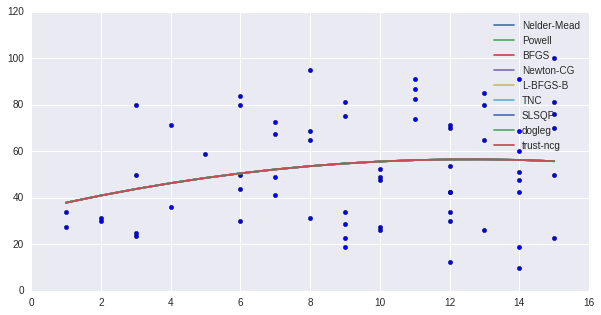

In [7]:
nterms = 3
model = Model_Poly(Y, X, nterms)

plt.figure(figsize = (10, 5))
theta_start = np.ones(nterms)
print('The difference between analytic and numerical gradient =',
      check_grad(model.sse, model.jac, theta_start))

estim = NLS(model)

for method in methods:
    estim.estimate(theta_start, method)
    print(method, estim.res.success, estim.theta_hat)
    if estim.res.success:
        Yhat = model.yhat(estim.theta_hat)
        plt.plot(X, Yhat, label = method)

plt.scatter(X, Y)
plt.legend()
plt.show()

## Estimate parameters and plot predictions for power model

The difference between analytic and numerical gradient = 1.18105212638e-05
Nelder-Mead False [-371.384  406.555    0.02 ]
Powell True [ 34.374   5.997   0.517]
CG False [ 30.777   9.126   0.409]
BFGS False [-47908.844  47943.896      0.   ]
Newton-CG True [ 15.793  22.316   0.238]
L-BFGS-B True [-2802.068  2837.176     0.003]
TNC False [  8.517  29.445   0.193]
COBYLA False [ 35.872   5.972   0.486]
SLSQP False [-448.649  483.968    0.017]
Hessian is required!
dogleg False [-448.649  483.968    0.017]
Hessian is required!
trust-ncg False [-448.649  483.968    0.017]


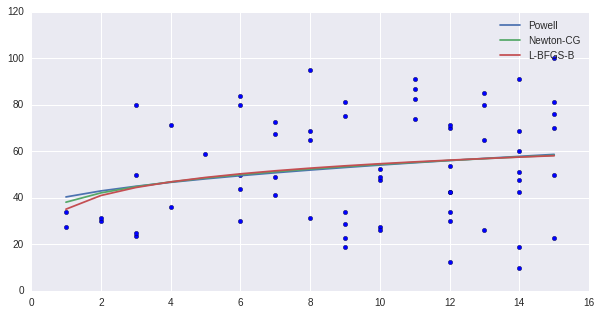

In [8]:
nterms = 3
model = Model_Power(Y, X)

plt.figure(figsize = (10, 5))
theta_start = [35, 5, .5]
print('The difference between analytic and numerical gradient =',
      check_grad(model.sse, model.jac, theta_start))

estim = NLS(model)

for method in methods:
    estim.estimate(theta_start, method)
    print(method, estim.res.success, estim.theta_hat)
    if estim.res.success:
        Yhat = model.yhat(estim.theta_hat)
        plt.plot(X, Yhat, label = method)

    
plt.scatter(X, Y)
plt.legend()
plt.show()

## Bootstrap

In [9]:
%%time

# Number of bootstrap samples
B = 1000
# Confidence level
alpha = .05
# Matrix of random indices
new_index = np.random.randint(Y.shape[0], size=[B, Y.shape[0]])

nterms = 3
model = Model_Poly(Y, X, nterms)
# Instantiate estimator
estim = NLS(model)
# Initial guess
theta_start = np.ones(nterms)
# Estimate parameters
estim.estimate(theta_start, method)
# Update initial guess for optimization speed
theta_start = estim.theta_hat

theta_b = []

for idx in new_index:
    # Resample the data and pass it to the model
    model = Model_Poly(Y[idx], X[idx], nterms)
    # Instantiate estimator
    estim = NLS(model)
    # Estimate
    estim.estimate(theta_start, method)
    # Store the results
    theta_b.append(estim.theta_hat)

# Convert the list to numpy array
theta_b = np.sort(np.vstack(theta_b), axis=0)

# Compute confidence intervals
lo = theta_b[np.floor(alpha * B)]
hi = theta_b[np.ceil((1-alpha) * B)]

print('NLS estimator = ', theta_start)
print('Lower bound   = ', lo)
print('Upper bound   = ', hi)

NLS estimator =  [ 34.537   3.497  -0.139]
Lower bound   =  [ 20.289  -1.474  -0.423]
Upper bound   =  [ 54.239   7.879   0.161]
CPU times: user 3.9 s, sys: 36 ms, total: 3.93 s
Wall time: 3.93 s


/home/khrapov/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/khrapov/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
